## Homework 01. Simple text processing.

In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

time: 498 ms


### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [3]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

time: 17.5 ms


In [4]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

time: 24.2 ms


In [5]:
data.shape

(1000, 2)

time: 20.1 ms


In [6]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


time: 23.4 ms


In [7]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

time: 361 ms


__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [8]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .
time: 209 ms


In [9]:
# task: preprocess each comment in train and test

texts_train = list(map(preprocess, texts_train))
texts_test = list(map(preprocess, texts_test))

time: 186 ms


In [10]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

time: 27.4 ms


### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [68]:
from collections import Counter, defaultdict

time: 30.5 ms


In [14]:
k=15
list(map(lambda pair: pair[0], Counter(' '.join(texts_train).split()).most_common()[:k]))

['.',
 ',',
 'you',
 'the',
 '"',
 'a',
 'to',
 'i',
 'and',
 '!',
 'is',
 'of',
 '=',
 'suck',
 'that']

time: 39.1 ms


In [16]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

token_counter = Counter(' '.join(texts_train).split())

bow_vocabulary = list(map(lambda pair: pair[0], token_counter.most_common(k)))

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']
time: 47.6 ms


In [22]:
idx2token = dict(enumerate(bow_vocabulary))
token2idx = dict(map(reversed, idx2token.items()))

def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    bow_vector = np.zeros(len(idx2token))
    for idx in map(token2idx.get, text.split()):
        if idx is None:
            continue
        bow_vector[idx] += 1

    return np.array(bow_vector, 'float32')

time: 30.1 ms


In [23]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

time: 115 ms


In [24]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

time: 34.9 ms


Now let's do the trick with `sklearn` logistic regression implementation:

In [25]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

time: 62.1 ms


/Users/ruaihm4/code/made/env_ml_made/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


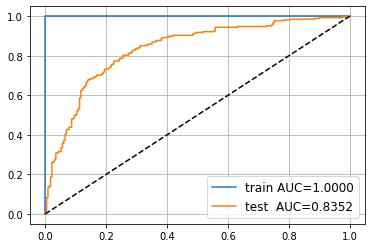

time: 650 ms


In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [28]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

time: 2.59 s


In [29]:
from utils import plot_train_process

time: 28.5 ms


In [59]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(len(bow_vocabulary), 2))

time: 31.2 ms


Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [60]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

time: 30.1 ms


In [61]:
opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.05)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=4, min_lr=3e-5)

time: 30.9 ms


In [62]:
X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32)
X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

time: 37.2 ms


Let's test that everything is fine

In [63]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

time: 31.3 ms


In [64]:
assert type(loss.item()) == float

time: 30.2 ms


Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [137]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)### YOUR CODE

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)### YOUR CODE


        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

time: 55.1 ms


Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

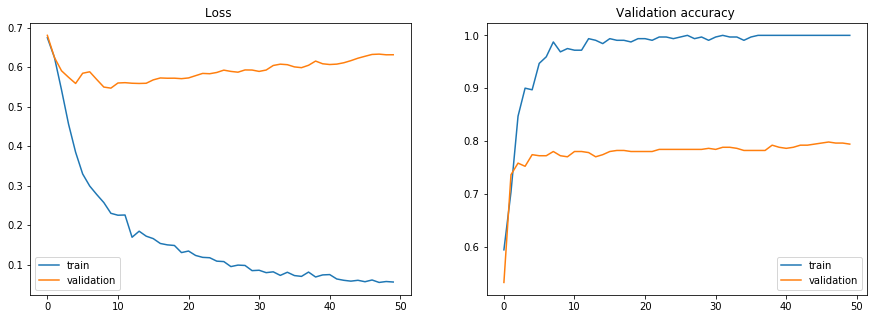

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
)

time: 19.4 s


In [66]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

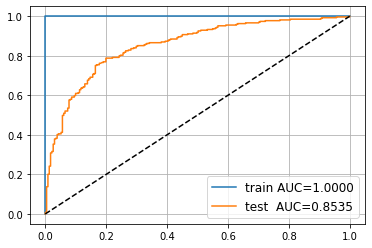

time: 230 ms


In [67]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [77]:
import plotly.express as px
import plotly.graph_objects as go

from matplotlib import pyplot as plt
%matplotlib inline

time: 44.4 ms


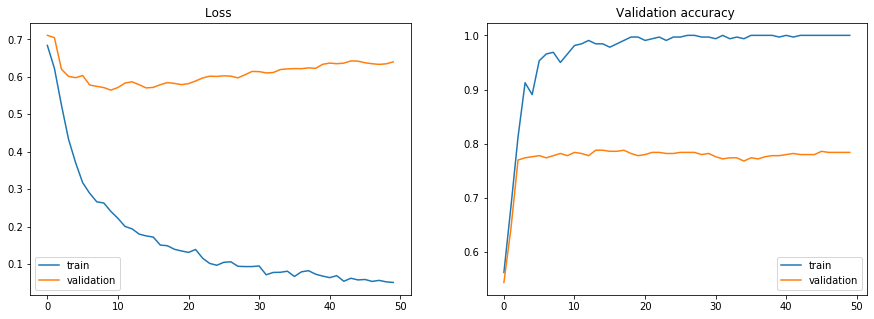

time: 3min 54s


In [74]:
k_values = [50, 100, 200, 300, 500, 700, 1000, 2000, 3000, 5000, 7000, 10000]
mode2aucs = defaultdict(list)

for k in k_values:
    # build vocab
    token_counter = Counter(' '.join(texts_train).split())
    bow_vocabulary = list(map(lambda pair: pair[0], token_counter.most_common(k)))
    idx2token = dict(enumerate(bow_vocabulary))
    token2idx = dict(map(reversed, idx2token.items()))

    # feature extraction
    X_train_bow_torch = torch.tensor(np.stack(list(map(text_to_bow, texts_train))), dtype=torch.float32)
    X_test_bow_torch = torch.tensor(np.stack(list(map(text_to_bow, texts_test))), dtype=torch.float32)

    # build model
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(len(bow_vocabulary), 2))
    opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.05)
    lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=4, min_lr=3e-5)

    train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

    for name, X, y in [
        ('train', X_train_bow_torch, y_train),
        ('test ', X_test_bow_torch, y_test)
    ]:
        proba = model(X).detach().cpu().numpy()[:, 1]
        mode2aucs[name].append(roc_auc_score(y, proba))

In [75]:
fig = go.Figure()

for mode in ['train', 'test ']:
    fig.add_trace(go.Scatter(
        x=k_values, y=mode2aucs[mode],
        mode='lines+markers', name=mode,
    ))
    
fig.update_layout(xaxis_title='k', yaxis_title='auc')
fig.show()

time: 196 ms


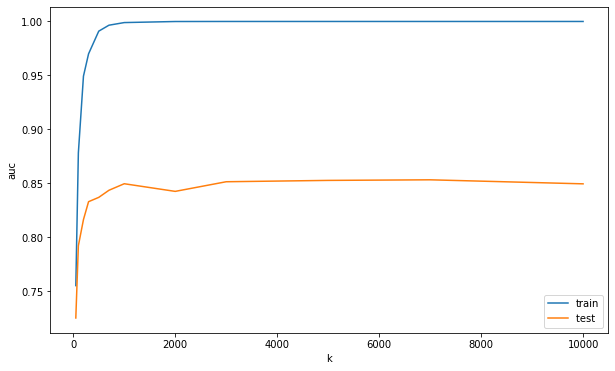

time: 261 ms


In [80]:
plt.figure(figsize=(10, 6))

for mode in ['train', 'test ']:
    plt.plot(k_values, mode2aucs[mode], label=mode)
    
plt.xlabel('k')
plt.ylabel('auc')
plt.legend()
plt.show()

Словаря размера 1000 вполне достаточно для достижения хорошего качества(test roc auc = 0.849). Однако есть переобучение.

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [107]:
from typing import List, Dict, Iterable

class TfIdf:
    def __init__(self, use_idf: bool = True):
        self.use_idf = use_idf
        self.idx2token: Dict[int, str] = None
        self.token2idx: Dict[str, int] = None
        self.idf: List[float] = None
        
    def fit(self, texts: List[str], k: int = 2000, alpha: float = 1e-5):
        token_counter = Counter(' '.join(texts).split())
        vocabulary = list(map(lambda pair: pair[0], token_counter.most_common(k)))
        
        self.idx2token = dict(enumerate(vocabulary))
        self.token2idx = dict(map(reversed, self.idx2token.items()))
        
        if self.use_idf:
            bow = self._bow(texts)
            n_texts_with_token = np.sum(bow > 0, axis=0, dtype=np.float32)
            self.idf = np.log(len(texts) / (n_texts_with_token + alpha))
        
        return self
        
    def _bow(self, texts: List[str]) -> Iterable[Iterable[float]]:
        bow = np.zeros((len(texts), len(self.idx2token)))
        for i, text in enumerate(texts):
            for idx in map(self.token2idx.get, text.split()):
                if idx is None:
                    continue
                bow[i, idx] += 1
        return bow
    
    def transform(self, texts: List[str]):
        X = self._bow(texts)
        
        if self.use_idf:
            X *= self.idf
        return X

time: 47.3 ms


Обычно в tf есть нормализация на количество слов в тексте, но сделал по формуле.

In [99]:
vectorizer = TfIdf()
vectorizer.fit(texts=texts_train, k=2000)
X_train_bow_torch = torch.tensor(vectorizer.transform(texts_train), dtype=torch.float32)
X_test_bow_torch = torch.tensor(vectorizer.transform(texts_test), dtype=torch.float32)

time: 168 ms


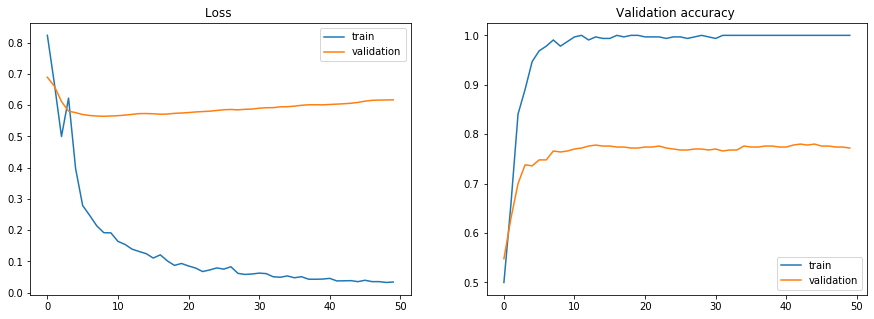

time: 3min 57s


In [104]:
k_values = [50, 100, 200, 300, 500, 700, 1000, 2000, 3000, 5000, 7000, 10000]
mode2aucs = defaultdict(list)

for k in k_values:
    vectorizer = TfIdf()
    vectorizer.fit(texts=texts_train, k=k)
    X_train_bow_torch = torch.tensor(vectorizer.transform(texts_train), dtype=torch.float32)
    X_test_bow_torch = torch.tensor(vectorizer.transform(texts_test), dtype=torch.float32)

    # build model
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(len(vectorizer.idf), 2))
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
    lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=4, min_lr=3e-5)

    train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

    for name, X, y in [
        ('train', X_train_bow_torch, y_train),
        ('test ', X_test_bow_torch, y_test)
    ]:
        proba = model(X).detach().cpu().numpy()[:, 1]
        mode2aucs[name].append(roc_auc_score(y, proba))

In [105]:
fig = go.Figure()

for mode in ['train', 'test ']:
    fig.add_trace(go.Scatter(
        x=k_values, y=mode2aucs[mode],
        mode='lines+markers', name=mode,
    ))
    
fig.update_layout(xaxis_title='k', yaxis_title='auc')
fig.show()

time: 177 ms


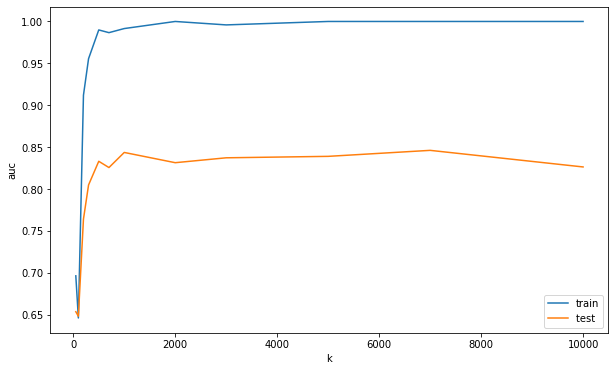

time: 267 ms


In [106]:
plt.figure(figsize=(10, 6))

for mode in ['train', 'test ']:
    plt.plot(k_values, mode2aucs[mode], label=mode)
    
plt.xlabel('k')
plt.ylabel('auc')
plt.legend()
plt.show()

Результаты примерно те же самые. Словаря размера 1000 вполне достаточно для достижения хорошего качества(test roc auc = 0.843). Однако есть переобучение.

Далее зафиксируем k=1000 для удобства.

In [108]:
k = 1000

time: 45.4 ms


### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [112]:
from sklearn.naive_bayes import GaussianNB

time: 44.6 ms


/Users/ruaihm4/code/made/env_ml_made/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



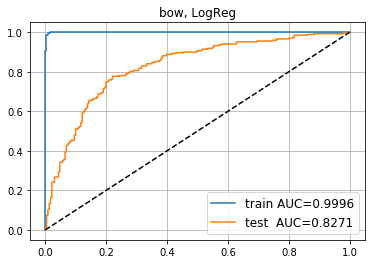

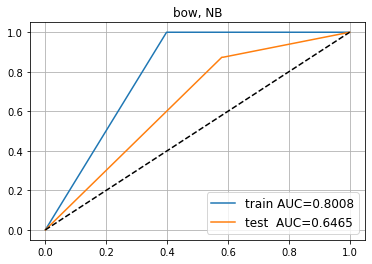

/Users/ruaihm4/code/made/env_ml_made/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



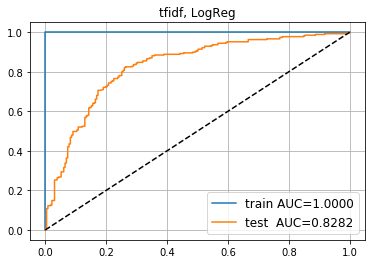

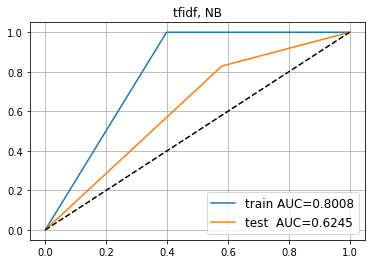

time: 1.01 s


In [116]:
for vec_type in ['bow', 'tfidf']:
    vectorizer = TfIdf(use_idf=(vec_type == 'tfidf'))
    vectorizer.fit(texts=texts_train, k=k)
    
    X_train = vectorizer.transform(texts_train)
    X_test = vectorizer.transform(texts_test)
    
    for model_type, model in [
        ('LogReg', LogisticRegression()),
        ('NB', GaussianNB())
    ]:
        model = model.fit(X_train, y_train)

        for name, X, y in [
            ('train', X_train, y_train),
            ('test ', X_test, y_test)
        ]:
            proba = model.predict_proba(X)[:, 1]
            auc = roc_auc_score(y, proba)
            plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

        plt.plot([0, 1], [0, 1], '--', color='black',)
        plt.title(f"{vec_type}, {model_type}")
        plt.legend(fontsize='large')
        plt.grid()
        plt.show()

_Your beautiful thoughts here_

Странно, но наивный Байес выдает вероятности только 0 или 1. Уж больно он уверенный. Из-за этого его roc auc сильно низкий, так что нет особого смысла сравнивать эти модели. Зато видно, что добавление idf не особо влияет на итоговый результат.

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [124]:
from gensim.models import KeyedVectors

wv_from_bin = KeyedVectors.load_word2vec_format(
    'data/word2vec_twitter_tokens.bin', binary=True, unicode_errors='ignore',
)

time: 1min 13s


In [126]:
wv_from_bin.wv.get_vector('word').shape

/Users/ruaihm4/code/made/env_ml_made/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



(400,)

time: 52.5 ms


Проверим сколько и каких токенов есть в словаре

In [151]:
good_tokens = []
bad_tokens = []

for token in set(' '.join(texts_train).split()):
    try:
        vec = wv_from_bin.wv.get_vector(token)
        good_tokens.append(token)
    except:
        bad_tokens.append(token)
len(good_tokens), len(bad_tokens)

/Users/ruaihm4/code/made/env_ml_made/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



(5049, 673)

time: 90.1 ms


В целом почти все токены есть, так что не будем заморачиваться по этому поводу

Будем переводить тексты в вектор при помощи усреднения векторов каждого токена в тексте

In [152]:
vec_size = 400

def text2vec(text: str):
    vectors = []
    for token in text.split():
        try:
            vec = wv_from_bin.wv.get_vector(token)
            vectors.append(vec)
        except:
            continue
    
    if len(vectors) == 0:
        return np.zeros(vec_size)
    else:
        vectors = np.array([num for vec in vectors for num in vec]).reshape(-1, vec_size)
        return np.mean(vectors, axis=0)

time: 47.3 ms


In [153]:
X_train = torch.tensor(np.stack(list(map(text2vec, texts_train))), dtype=torch.float32)
X_test = torch.tensor(np.stack(list(map(text2vec, texts_test))), dtype=torch.float32)

/Users/ruaihm4/code/made/env_ml_made/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



time: 7.48 s


### lr=3e-3, weight_decay=0.05, без lr_scheduler

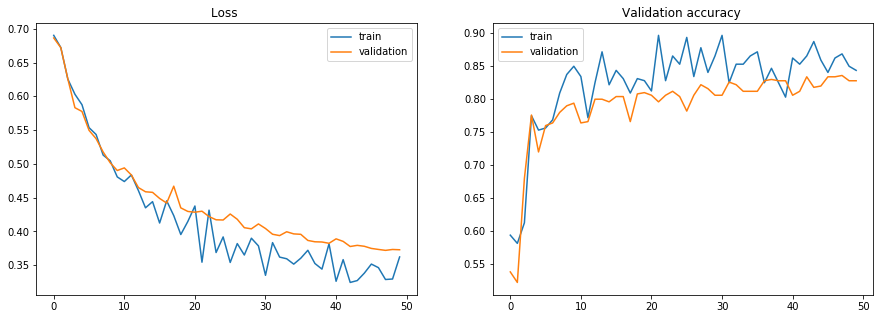

train: roc auc = 0.9566520784238286
test : roc auc = 0.9218043418786913
time: 21 s


In [154]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(vec_size, 2))
opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.05)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=50000, min_lr=3e-5)

train_model(
    model, opt, lr_scheduler, 
    X_train, y_train_torch, 
    X_test, y_test_torch, 
    n_iterations=500,
)

for name, X, y in [
    ('train', X_train, y_train),
    ('test ', X_test, y_test)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    print(f"{name}: roc auc = {roc_auc_score(y, proba)}")

Стало заметно лучше. Это логично, поскольку w2v обучен на твитах, что очень похоже на наши комменты.

Видно, что это не предел(при этом переобучения практически нет). Увеличим количество эпох.

### lr=3e-3, weight_decay=0.05, без lr_scheduler + больше эпох

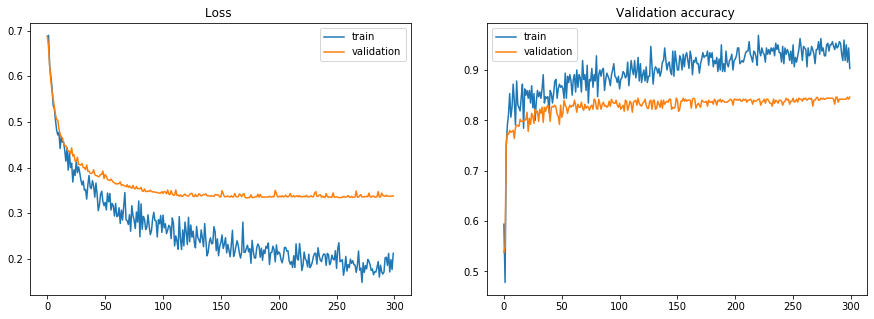

train: roc auc = 0.9910065887558313
test : roc auc = 0.9288047763884195
time: 1min 56s


In [155]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(vec_size, 2))
opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.05)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=50000, min_lr=3e-5)

train_model(
    model, opt, lr_scheduler, 
    X_train, y_train_torch, 
    X_test, y_test_torch, 
    n_iterations=3000,
)

for name, X, y in [
    ('train', X_train, y_train),
    ('test ', X_test, y_test)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    print(f"{name}: roc auc = {roc_auc_score(y, proba)}")

Качество немного подросло. Где-то к 1000 эпохе началось расхождение train и test лосса(переобучение). Попробуем увеличить штраф за веса.

### lr=3e-3, weight_decay=0.2, без lr_scheduler + больше эпох

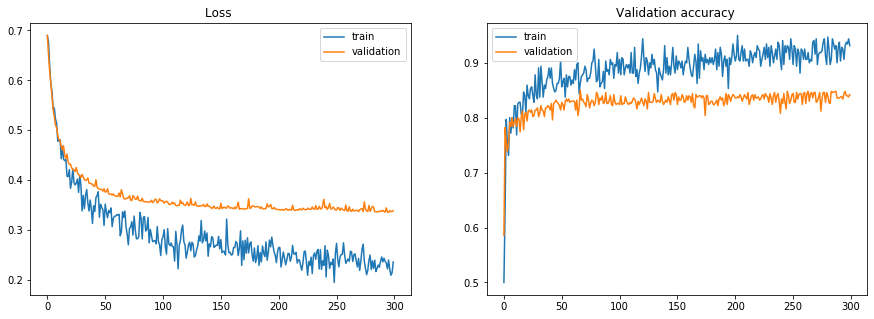

train: roc auc = 0.9828788534602992
test : roc auc = 0.9306232800656593
time: 1min 54s


In [159]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(vec_size, 2))
opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.2)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=50000, min_lr=3e-5)

train_model(
    model, opt, lr_scheduler, 
    X_train, y_train_torch, 
    X_test, y_test_torch, 
    n_iterations=3000,
)

for name, X, y in [
    ('train', X_train, y_train),
    ('test ', X_test, y_test)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    print(f"{name}: roc auc = {roc_auc_score(y, proba)}")

Стало еще чуточку лучше. Лосс теперь выходит на плато: добавим шедулер и еще больше эпох.

### lr=3e-3, weight_decay=0.2, с lr_scheduler + еще больше эпох

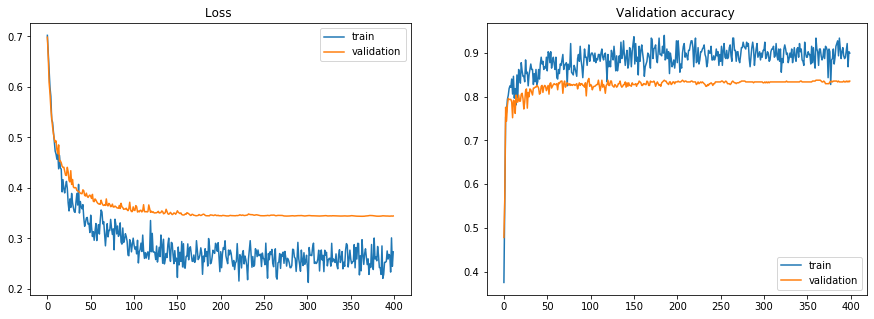

train: roc auc = 0.976963401144616
test : roc auc = 0.9295450522216322
time: 2min 31s


In [160]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(vec_size, 2))
opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=0.2)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.8, patience=10, min_lr=1e-4)

train_model(
    model, opt, lr_scheduler, 
    X_train, y_train_torch, 
    X_test, y_test_torch, 
    n_iterations=4000,
)

for name, X, y in [
    ('train', X_train, y_train),
    ('test ', X_test, y_test)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    print(f"{name}: roc auc = {roc_auc_score(y, proba)}")

**Вывод:**

Tranfer learning - наше все. Тюнинг параметров помогает выбить немного качества: поднял roc auc с 0.921 до 0.93.